In [38]:
import numpy as np
import matplotlib.pyplot as plt


In [39]:
# Constants
NUM_STATES = 5  # Number of non-terminal states (A-E)
START_STATE = 3  # Starting state index ('C')
TERMINAL_LEFT = 0  # Index for the left terminal state (before 'A')
TERMINAL_RIGHT = 6  # Index for the right terminal state (after 'E')
TRUE_VALUES = np.array([1/6, 2/6, 3/6, 4/6, 5/6])  # True values for states A-E
ALPHA_VALUES_TD = [0.15, 0.1, 0.05]  # Step sizes for TD(0) method
ALPHA_VALUES_MC = [0.01, 0.02, 0.03, 0.04]  # Step sizes for MC method
NUM_EPISODES = 100  # Number of episodes per run
NUM_RUNS = 100  # Number of independent runs for averaging


In [40]:
def generate_episode():
    """
    Generates an episode by simulating a random walk starting from START_STATE.

    Returns:
        list: A list of (state, reward, next_state) tuples representing the episode.
    """
    state = START_STATE
    episode = []
    while True:
        # Check if the current state is terminal
        if state == TERMINAL_LEFT or state == TERMINAL_RIGHT:
            break
        # Randomly choose the next state (left or right)
        next_state = state - 1 if np.random.rand() < 0.5 else state + 1
        # Determine the reward based on the next state
        if next_state == TERMINAL_LEFT:
            reward = 0  # Reaching the left terminal state yields a reward of 0
        elif next_state == TERMINAL_RIGHT:
            reward = 1  # Reaching the right terminal state yields a reward of 1
        else:
            reward = 0  # All other transitions yield a reward of 0
        episode.append((state, reward, next_state))
        state = next_state  # Move to the next state
    return episode


In [41]:
def td0(value_function, alpha):
    """
    Performs a single TD(0) update using the generated episode.

    Args:
        value_function (np.ndarray): Current estimates of the value function.
        alpha (float): Learning rate for the TD(0) update.
    """
    episode = generate_episode()
    for state, reward, next_state in episode:
        # Determine the target value
        if next_state == TERMINAL_LEFT or next_state == TERMINAL_RIGHT:
            target = reward  # Terminal state
        else:
            target = reward + value_function[next_state]  # Non-terminal state
        # Update the value function estimate
        value_function[state] += alpha * (target - value_function[state])


In [42]:
def mc(value_function, alpha):
    """
    Performs a single constant-alpha Monte Carlo update using the generated episode.

    Args:
        value_function (np.ndarray): Current estimates of the value function.
        alpha (float): Learning rate for the MC update.
    """
    episode = generate_episode()
    G = episode[-1][1]  # The return G is the reward at the terminal state
    visited_states = set()
    for state, _, _ in episode:
        if state in {TERMINAL_LEFT, TERMINAL_RIGHT}:
            continue  # Skip terminal states
        if state not in visited_states:
            # Update the value function estimate
            value_function[state] += alpha * (G - value_function[state])
            visited_states.add(state)  # Ensure each state is updated only once per episode


In [43]:
def run_method(method_func, alpha_values, num_episodes):
    """
    Runs the specified method over multiple episodes and returns RMS errors.

    Args:
        method_func (function): The TD(0) or MC function to run.
        alpha_values (list): List of alpha values to use.
        num_episodes (int): Number of episodes per run.

    Returns:
        dict: RMS errors for each alpha value, averaged over runs.
    """
    rms_errors = {alpha: np.zeros(num_episodes) for alpha in alpha_values}
    for alpha in alpha_values:
        for _ in range(NUM_RUNS):
            # Initialize value function estimates
            value_function = np.ones(NUM_STATES + 2) * 0.5
            value_function[TERMINAL_LEFT] = 0  # Terminal state value
            value_function[TERMINAL_RIGHT] = 0  # Terminal state value
            for ep in range(num_episodes):
                # Perform method update
                method_func(value_function, alpha)
                # Calculate RMS error over non-terminal states
                error = np.sqrt(np.mean((value_function[1:6] - TRUE_VALUES) ** 2))
                rms_errors[alpha][ep] += error
        # Average errors over runs
        rms_errors[alpha] /= NUM_RUNS
    return rms_errors


In [44]:
def plot_rms_errors(rms_errors_td, rms_errors_mc):
    """
    Plots the empirical RMS error curves for TD(0) and MC methods.

    Args:
        rms_errors_td (dict): RMS errors for TD(0) method.
        rms_errors_mc (dict): RMS errors for MC method.
    """
    plt.figure(figsize=(10, 5))
    x = np.arange(1, NUM_EPISODES + 1)

    # Plot TD(0) curves
    for alpha in ALPHA_VALUES_TD:
        plt.plot(x, rms_errors_td[alpha], color='blue', linewidth=1, label=f'TD α={alpha}')

    # Plot MC curves with different line styles
    line_styles_mc = ['--', '-.', ':', (0, (5, 1))]
    for idx, alpha in enumerate(ALPHA_VALUES_MC):
        plt.plot(x, rms_errors_mc[alpha], color='red', linestyle=line_styles_mc[idx % len(line_styles_mc)],
                 linewidth=1, label=f'MC α={alpha}')

    plt.xlabel('Walks / Episodes')
    plt.ylabel('Empirical RMS error, averaged over states')
    plt.title('Empirical RMS error, averaged over states')
    plt.xticks(np.arange(0, NUM_EPISODES + 1, 20))
    plt.yticks(np.arange(0, 0.65, 0.1))
    plt.ylim(0, 0.25)
    plt.xlim(0, NUM_EPISODES)
    plt.legend()
    plt.show()


In [45]:
def plot_value_estimates(value_functions, episodes_to_plot):
    """
    Plots the estimated value function after specified episodes.

    Args:
        value_functions (list): List of value function estimates.
        episodes_to_plot (list): Episodes after which the estimates were recorded.
    """
    plt.figure(figsize=(10, 5))
    states = ['A', 'B', 'C', 'D', 'E']
    x = np.arange(1, NUM_STATES + 1)

    # Plot true values
    plt.plot(x, TRUE_VALUES, color='black', marker='o', label='True values')
    # Plot initial value (V=0.5)
    plt.plot(x, np.ones(NUM_STATES) * 0.5, color='black', linestyle='--', marker='o', label='0')

    # Colors for different episodes
    colors = ['red', 'green', 'blue']
    for idx, values in enumerate(value_functions):
        plt.plot(x, values[1:6], color=colors[idx], marker='o', label=f'{episodes_to_plot[idx]}')

    plt.xlabel('State')
    plt.ylabel('Value Estimate')
    plt.title('Estimated value')
    plt.xticks(x, states)
    plt.yticks(np.arange(0, 1.1, 0.2))
    plt.ylim(0, 1.0)
    plt.legend()
    plt.show()


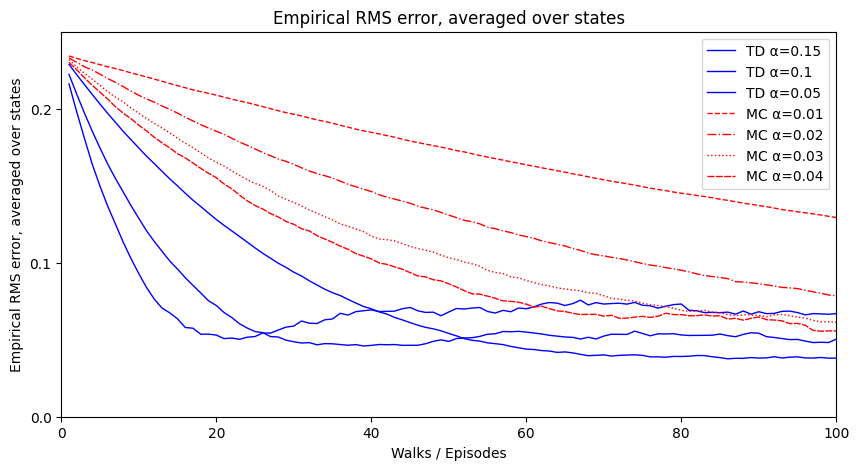

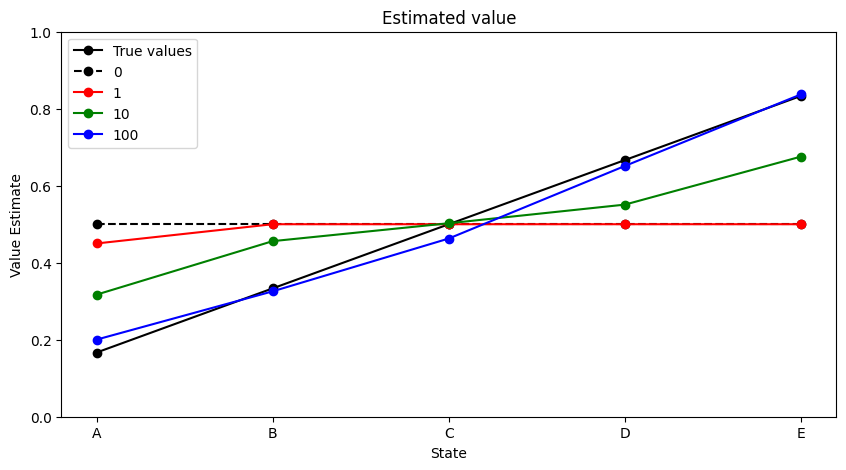

In [46]:
def main():
    """
    Main function to run the simulations and plot the results.
    """
    # Run TD(0) and MC methods and collect RMS errors
    rms_errors_td = run_method(td0, ALPHA_VALUES_TD, NUM_EPISODES)
    rms_errors_mc = run_method(mc, ALPHA_VALUES_MC, NUM_EPISODES)

    # Plot RMS error curves
    plot_rms_errors(rms_errors_td, rms_errors_mc)

    # Run TD(0) for specific episodes to get value estimates
    value_function = np.ones(NUM_STATES + 2) * 0.5
    value_function[TERMINAL_LEFT] = 0
    value_function[TERMINAL_RIGHT] = 0
    episodes_to_plot = [1, 10, 100]
    value_functions = []
    for ep in range(1, max(episodes_to_plot) + 1):
        td0(value_function, alpha=0.1)
        if ep in episodes_to_plot:
            value_functions.append(value_function.copy())

    # Plot value estimates after specific episodes
    plot_value_estimates(value_functions, episodes_to_plot)

if __name__ == '__main__':
    main()
